# Reti Neurali: filtro anti-hater per social network - Tutorial Giovanni Corigliano

Obiettivo: creare un modello di deep learning in grado di filtrare i commenti negativi.

Tutorial realizzato da **Giovanni Corigliano**:[Linkedin](https://www.linkedin.com/in/giovanni-corigliano-9819b7225/)


Seguimi e lascia un like !

In [1]:
!pip install iterative-stratification

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Importazione e analisi esplorativa del dataset

In [3]:
BASE_URL = " https://proai-datasets.s3.eu-west-3.amazonaws.com/"
df = pd.read_csv(BASE_URL + "Filter_Toxic_Comments_dataset.csv")

In [4]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


Il dataset contiene commenti utente e la loro classificazione. In particolare, le classi sono 6:


*   toxic
*   severe_toxic
*   obscene
*   threat
*   insult
*   identity_hate

Ogni commento può appartenere a nessuna, ad una o a più classi. Si deduce che si tratta di un caso di classificazione multilabel.


In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.219952
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.748260
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


Analizziamo il dataset:
- Contiene un totale di 159571 commenti.
- La classe più rappresentata è "toxic",  seguita da "obscene" e "insult".
- Possiamo inoltre notare che il valore max della feature "sum_injurious" è uguale a 6 dunque ci sono commenti che appartengono a tutte e sei le classi.

In [6]:
df.isna().sum()

,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0
sum_injurious,0


Abbiamo verificato che non sono presenti dati mancanti.

In [7]:
label_counts = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for label in label_counts:
  print(df[label].value_counts())

toxic
0    144277
1     15294
Name: count, dtype: int64
severe_toxic
0    157976
1      1595
Name: count, dtype: int64
obscene
0    151122
1      8449
Name: count, dtype: int64
threat
0    159093
1       478
Name: count, dtype: int64
insult
0    151694
1      7877
Name: count, dtype: int64
identity_hate
0    158166
1      1405
Name: count, dtype: int64


Questo risultato mostra come i commenti siano distribuiti tra le diverse classi. In particolare, il valore 1 indica l'appartenenza a una determinata classe, mentre 0 rappresenta la non appartenenza. È evidente un forte sbilanciamento nel dataset: i commenti positivi sono nettamente più numerosi rispetto a quelli negativi.

In [8]:
counts = df[['sum_injurious']].value_counts()
counts

,count
sum_injurious,
0,143346
1,6360
3,4209
2,3480
4,1760
5,385
6,31


Si riconferma la netta maggioranza di commenti positivi, cioè con 0 etichette

### Costruiamo un grafico per osservare la distribuzione dei dati

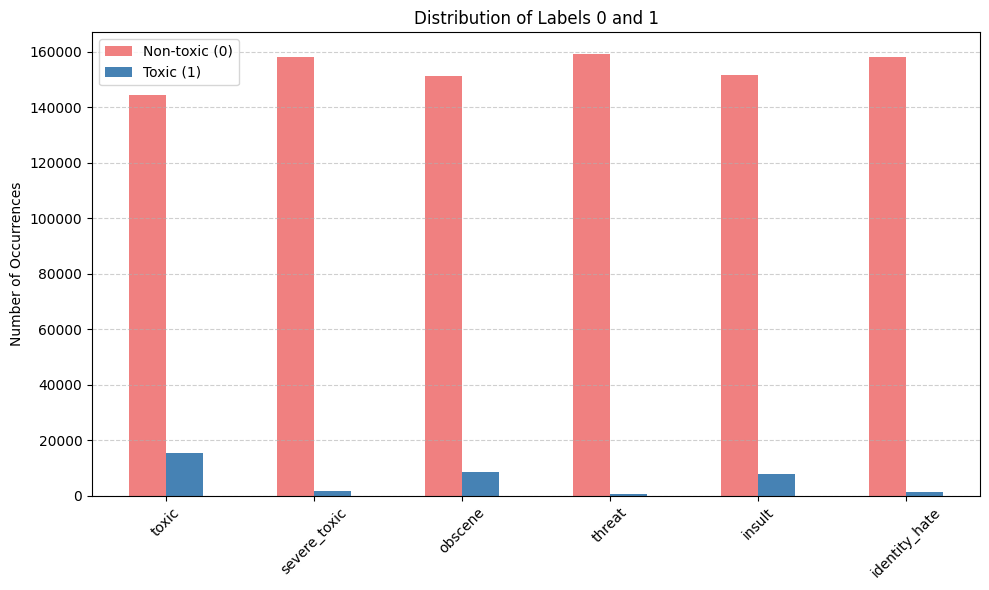

In [9]:
# Count the number of 1s and 0s for each column
counts = df[label_counts].apply(lambda col: col.value_counts()).fillna(0).astype(int).T

# Rename columns for clarity
counts.columns = ['Non-toxic (0)', 'Toxic (1)']

# Grouped bar plot
counts.plot(kind='bar', stacked=False, figsize=(10, 6), color=['lightcoral', 'steelblue'])
plt.title('Distribution of Labels 0 and 1')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Il grafico conferma quanto osservato finora: la maggior parte dei commenti appartiene alla classe non tossica, mentre quelli tossici sono nettamente inferiori.

Questa marcata disparità rende necessario l’utilizzo di tecniche di bilanciamento delle classi, al fine di riequilibrare il dataset e migliorare le performance del modello.

### Costruiamo un grafico per osservare la lunghezza dei commenti

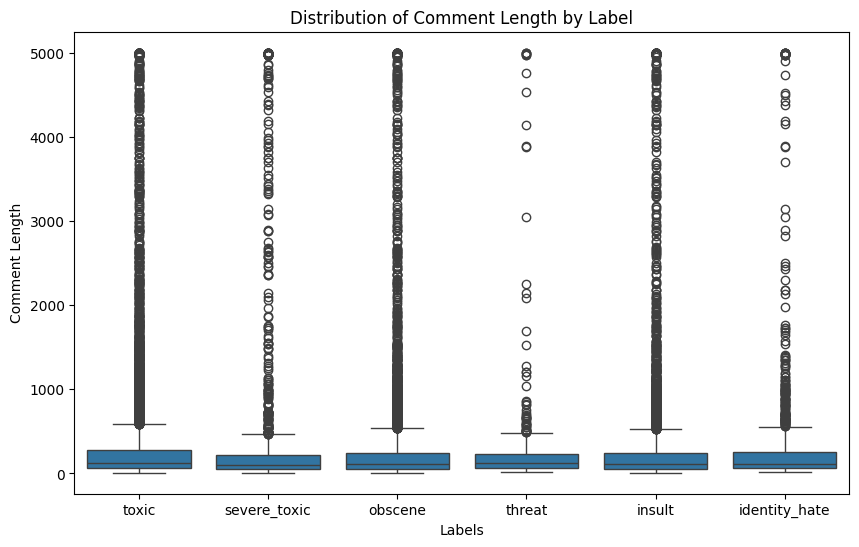

In [10]:
# Calculate the length of the comments
df['comment_length'] = df['comment_text'].apply(len)

# Create a "melted" DataFrame to have a single column for labels
melted_df = df.melt(id_vars=['comment_length'], value_vars=label_counts,
                    var_name='label', value_name='is_present')

# Filter only comments where the label is present
melted_df = melted_df[melted_df['is_present'] == 1]

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='comment_length', data=melted_df)
plt.title('Distribution of Comment Length by Label')
plt.xlabel('Labels')
plt.ylabel('Comment Length')
plt.show()

Il grafico con i boxplot consente di osservare la distribuzione della lunghezza dei commenti per ciascuna etichetta. Si nota chiaramente la presenza di numerosi outlier in tutte le classi, in particolare nella categoria "toxic". Questo indica che, sebbene la maggior parte dei commenti sia piuttosto breve, esistono anche commenti significativamente più lunghi.

# Pre-processing dei dati

Procediamo con la pulizia del testo. A tal fine, definiamo una funzione che ci permetta di rimuovere elementi indesiderati dai commenti, come numeri, punteggiatura e stop words.

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Text cleaning function
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [13]:
df['comment_text'] = df['comment_text'].apply(clean_text)
df['comment_text'].head()

,comment_text
0,explanation edits made username hardcore metal...
1,aww matches background colour seemingly stuck ...
2,hey man really trying edit war guy constantly ...
3,make real suggestions improvement wondered sec...
4,sir hero chance remember page


A questo punto, possiamo procedere con la suddivisione del dataset in set di addestramento, validazione e test. Utilizzeremo MultilabelStratifiedShuffleSplit, una tecnica appositamente pensata per la classificazione multilabel, che consente di mantenere la proporzione di ciascuna etichetta all'interno di tutti e tre i set.

A tal fine viene eseguito un primo split per suddividere il dataset iniziale in train e temp.

Successivamente si suddivide temp per ottenere validation e test.

In [14]:
X = df['comment_text']
y = df[label_counts]

# First split to obtain training and temporary sets (validation + test)
mss_train_temp = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)

for train_index, temp_index in mss_train_temp.split(X, y):
    X_train, X_temp = X.iloc[train_index], X.iloc[temp_index]
    y_train, y_temp = y.iloc[train_index], y.iloc[temp_index]

# Second split to obtain validation and test sets from the temporary set
mss_val_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_index, test_index in mss_val_test.split(X_temp, y_temp):
    X_val, X_test = X_temp.iloc[val_index], X_temp.iloc[test_index]
    y_val, y_test = y_temp.iloc[val_index], y_temp.iloc[test_index]

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (95742,) (95742, 6)
Validation set size: (31914,) (31914, 6)
Test set size: (31915,) (31915, 6)


Proseguiamo con la tokenizzazione, un processo che consiste nel trasformare i commenti testuali in sequenze di numeri interi. Ogni numero rappresenta una parola specifica del vocabolario costruito a partire dal dataset. In questo modo, il testo viene convertito in una forma numerica che può essere facilmente elaborata da un modello di machine learning per l’addestramento e la predizione.

In [15]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [16]:
train_sequences= tokenizer.texts_to_sequences(X_train)
validation_sequences= tokenizer.texts_to_sequences(X_val)
test_sequences= tokenizer.texts_to_sequences(X_test)

In [17]:
vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

152736

In [18]:
maxlen = len(max(train_sequences,key=len))
maxlen

1235

PADDING
- Quando si lavora con modelli di deep learning per testi (come LSTM, GRU o CNN), è necessario che tutte le sequenze abbiano la stessa lunghezza. Tuttavia, i commenti/testi non hanno lunghezza fissa. La funzione pad_sequences di Keras risolve questo problema.

- pad_sequences aggiunge zeri (per default) all’inizio delle sequenze (padding pre) per farle tutte della stessa lunghezza: quella specificata da maxlen.

In [19]:
padded_train_sequences = pad_sequences(train_sequences,maxlen=maxlen)
padded_validation_sequences = pad_sequences(validation_sequences,maxlen=maxlen)
padded_test_sequences = pad_sequences(test_sequences,maxlen=maxlen)

Poiché nella fase iniziale dell'analisi esplorativa abbiamo riscontrato un marcato sbilanciamento tra commenti positivi e negativi, è necessario applicare tecniche di bilanciamento prima di procedere con la creazione del modello.

In questo caso, implementeremo una funzione in grado di generare nuovi campioni sintetici per le classi minoritarie.
Dal momento che SMOTE non è adatto a problemi di classificazione multilabel, utilizzeremo una sua variante più adatta: MLSMOTE (Multi-Label Synthetic Minority Over-sampling Technique).

In [23]:
def MLSMOTE(X, y, n_samples=10000, k_neighbors=5, random_state=42):
    """Apply MLSMOTE to generate new synthetic multilabel samples."""
    np.random.seed(random_state)

    # Find minority classes
    labels = y.sum(axis=0)
    min_classes = labels[labels < labels.median()].index

    # Apply SMOTE only to examples that have at least one minority class
    minority_indices = y[min_classes].sum(axis=1) > 0
    X_minority, y_minority = X[minority_indices], y[minority_indices]

    # Find your nearest neighbors
    neigh = NearestNeighbors(n_neighbors=k_neighbors)
    neigh.fit(X_minority)

    synthetic_X, synthetic_y = [], []
    for _ in range(n_samples):
        index = np.random.randint(0, len(X_minority))
        x_sample = X_minority.iloc[index]
        y_sample = y_minority.iloc[index]

        # Find your nearest neighbors
        neighbors = neigh.kneighbors([x_sample], return_distance=False)[0]
        neighbor = X_minority.iloc[np.random.choice(neighbors)]

        # Generates a new sample by interpolating between the selected sample and its neighbor
        new_sample = x_sample + np.random.rand() * (neighbor - x_sample)

        # The new sample label is the combination of the original labels
        new_label = y_sample | y_minority.iloc[np.random.choice(neighbors)]

        synthetic_X.append(new_sample)
        synthetic_y.append(new_label)

    return np.vstack([X, np.array(synthetic_X)]), np.vstack([y, np.array(synthetic_y)])

In [24]:
X_train_df = pd.DataFrame(padded_train_sequences)
X_train_df.reset_index(drop=True, inplace=True)  ### approfondire
y_train_reset = y_train.reset_index(drop=True)

In [25]:
X_train_resampled, y_train_resampled = MLSMOTE(X_train_df, y_train_reset, n_samples=5000)

In [26]:
X_train_resampled = np.array(X_train_resampled)
y_train_resampled = np.array(y_train_resampled)

print("Balanced data with MLSMOTE:")
print(f"New shape X_train: {X_train_resampled.shape}")
print(f"New shape y_train: {y_train_resampled.shape}")
print("-------------")
print(vocabulary_size)
print(maxlen)

Balanced data with MLSMOTE:
New shape X_train: (100742, 1235)
New shape y_train: (100742, 6)
-------------
152736
1235


In [27]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

# Creazione del modello

Creiamo una rete neurale sequenziale costituita dai seguenti layers:


*   **embedding**: converte gli input testuali in vettori densi di dimensioni fisse
*   **convolutional**: utilizzato per rilevare caratteristiche locali all'interno di sequenze
*   **maxpooling**: riduce la dimensionalità degli output del layer convoluzionale
*   **bidirectional LSTM**: consente al modello di avere informazioni sia dalle sequenze precedenti che da quelle successive
*   **LSTM**: un altro strato LSTM,  questa volta unidirezionale, che restituisce solo l'ultimo stato nascosto
*   **dense**: uno strato denso per combinare le caratteristiche estratte in precedenza e prepararle per la classificazione finale
*   **dropout**: aiuta a prevenire l'overfitting
*   **dense**: per la classificazione multilabel, dove ciascun neurone dell'output rappresenta una classe e la sigmoide restituisce la probabilità che ciascuna classe sia presente.









In [28]:
clear_session()
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=152736, output_dim=128))
model_LSTM.add(Conv1D(128,5, activation="relu")),
model_LSTM.add(MaxPooling1D(pool_size=2)),
model_LSTM.add(Bidirectional(LSTM(32, return_sequences=True)))
model_LSTM.add(LSTM(32))
model_LSTM.add(Dense(units=32, activation="relu")),
model_LSTM.add(Dropout(0.5)),
model_LSTM.add(Dense(6,activation='sigmoid'))

model_LSTM.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy", "precision", "recall"]
)

model_LSTM.build((None,maxlen))
model_LSTM.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1235, 128)      │    19,550,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1231, 128)      │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 615, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 615, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,687,142 (75.10 MB)

 Trainable params: 19,687,142 (75.10 MB)

 Non-trainable params: 0 (0.00 B)

Aggiungiamo un `EarlyStopping` per interrompere l'addestramento nel caso in cui non ci sia più una diminuzione della `val_loss` dopo un certo numero di epoche consecutive, nel nostro caso 5.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model_LSTM.fit(X_train_resampled, y_train_resampled, validation_data=(padded_validation_sequences, y_val), epochs=10, callbacks=[early_stopping], batch_size=128)

Epoch 1/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 103s 120ms/step - accuracy: 0.4991 - loss: 0.2770 - precision: 0.3621 - recall: 0.1575 - val_accuracy: 0.9949 - val_loss: 0.0780 - val_precision: 0.7684 - val_recall: 0.5606
Epoch 2/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 136s 119ms/step - accuracy: 0.9094 - loss: 0.1418 - precision: 0.8015 - recall: 0.4651 - val_accuracy: 0.9949 - val_loss: 0.0777 - val_precision: 0.7540 - val_recall: 0.5599
Epoch 3/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 143s 120ms/step - accuracy: 0.9875 - loss: 0.1158 - precision: 0.8058 - recall: 0.5444 - val_accuracy: 0.9949 - val_loss: 0.0774 - val_precision: 0.7044 - val_recall: 0.5793
Epoch 4/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 143s 121ms/step - accuracy: 0.9921 - loss: 0.0946 - precision: 0.8255 - recall: 0.6296 - val_accuracy: 0.9949 - val_loss: 0.0840 - val_precision: 0.6215 - val_recall: 0.6247
Epoch 5/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 140s 119ms/step - accuracy: 0.9935 - loss: 0.0824 - precision: 0.8358 - recall: 0.6871 - val_accuracy: 0

Valutazione dei risultati ottenuti

Il processo di addestramento si è interrotto all'ottava epoca a causa dell'assenza di ulteriori miglioramenti nella validation loss, segnale che l'early stopping è stato attivato correttamente.

- Accuracy: l’accuratezza del modello aumenta rapidamente tra la prima e la seconda epoca, stabilizzandosi poi intorno al 99%. L'accuracy sul set di validazione rimane costantemente alta, indicando una buona capacità del modello di generalizzare su dati non visti.

- Loss: la loss sul set di addestramento decresce progressivamente, segnalando che il modello sta effettivamente apprendendo. Tuttavia, la validation loss non segue lo stesso andamento: a partire dalla quarta epoca, tende ad aumentare, il che suggerisce un possibile inizio di overfitting.

- Precision e Recall: entrambe le metriche migliorano nel tempo, segno che il modello sta affinando la sua capacità di individuare correttamente le classi positive. Tuttavia, si osservano delle fluttuazioni, in particolare nella precisione sul set di validazione, il che può indicare una certa instabilità del modello nel mantenere prestazioni elevate su dati nuovi.

### Valutazione del modello sul set di test.

In [ ]:
model_LSTM.evaluate(padded_test_sequences,y_test)

998/998 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9939 - loss: 0.0793 - precision: 0.6761 - recall: 0.5691


[0.07938899844884872,
 0.9937959909439087,
 0.6963478326797485,
 0.570289134979248]

**L’accuratezza** risulta elevata, indicando che il modello è complessivamente efficace nelle sue previsioni.

La **loss** è coerente con quanto osservato durante le fasi di addestramento e validazione, suggerendo che il modello non sta incorrendo in un grave overfitting.

Tuttavia, si rileva un calo nelle metriche di precisione e recall rispetto ai valori ottenuti in fase di addestramento. Questo indica che il modello potrebbe incontrare difficoltà nel generalizzare su nuove istanze, in particolare nel gestire correttamente il bilanciamento tra falsi positivi e falsi negativi.

Queste osservazioni suggeriscono l’opportunità di ulteriori interventi, tra cui:

- Regolare la soglia di classificazione, per migliorare la precisione o il recall in base alle priorità dell’applicazione.

- Applicare tecniche di regolarizzazione o aumentare la quantità di dati, al fine di ridurre potenziali problemi di overfitting e migliorare la generalizzazione del modello.

### Definiamo una funzione per la rappresentazione grafica delle learning curves

In [ ]:
def plot_learning_curves(history):
    """
    Generate and visualize learning curve graphs for accuracy and loss.

    history: The history object returned by the model's fit method.

    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curve: Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


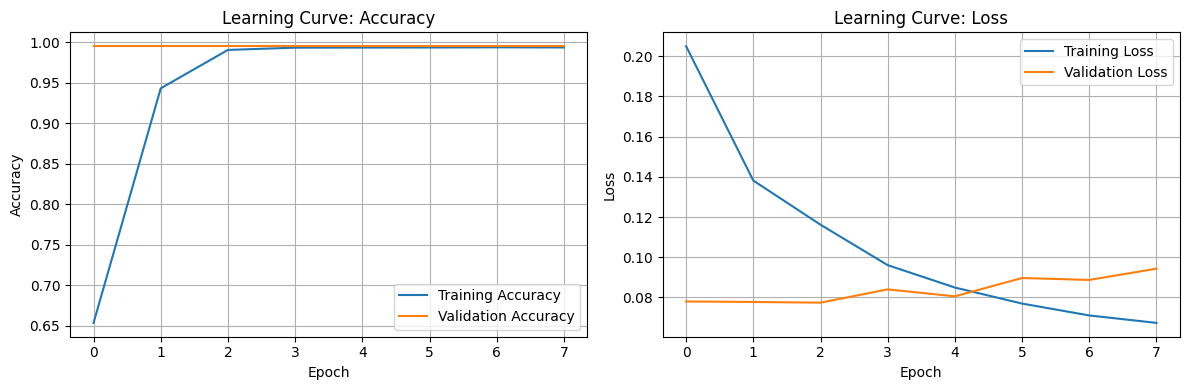

In [ ]:
plot_learning_curves(history)

I due grafici illustrano l’andamento dell’accuracy e della loss nel corso delle epoche, mettendo a confronto i risultati sui set di addestramento e di validazione.

Si osserva che l’accuracy tende a convergere, raggiungendo un plateau dopo le prime epoche, segno che il modello ha appreso una rappresentazione stabile dei dati.

Per quanto riguarda la loss, si nota un andamento più irregolare nel set di validazione, con alcune oscillazioni che potrebbero indicare variazioni nella capacità del modello di generalizzare su dati non visti.

### Definiamo una funzione per la rappresentazione grafica delle matrici di confusione

In [ ]:
def plot_multilabel_confusion_matrices(y_true, y_pred, labels, threshold=0.5):
    """
    Compute and display confusion matrices for each label in a multilabel context.
    y_true: numpy array of size (n_samples, n_labels) with the true labels.
    y_pred: numpy array of size (n_samples, n_labels) with the labels predicted by the model (probability).
    labels: list of labels (or index of labels) for which to compute the confusion matrix.
    threshold: threshold to binarize the probabilities.

    """
    # Binarize y_pred based on threshold
    y_pred_binary = (y_pred >= threshold).astype(int)

    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(5 * num_labels, 5))

    for idx, label in enumerate(labels):
        # Extract the actual and expected labels for the current label
        y_true_label = y_true[:, idx]
        y_pred_label = y_pred_binary[:, idx]

        # Calculate the confusion matrix for the current label
        cm = confusion_matrix(y_true_label, y_pred_label, labels=[0, 1])

        # Confusion matrix
        ax = axes[idx] if num_labels > 1 else axes
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(f'Confusion matrix for {label}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Real')
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])

    plt.tight_layout()
    plt.show()

998/998 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step


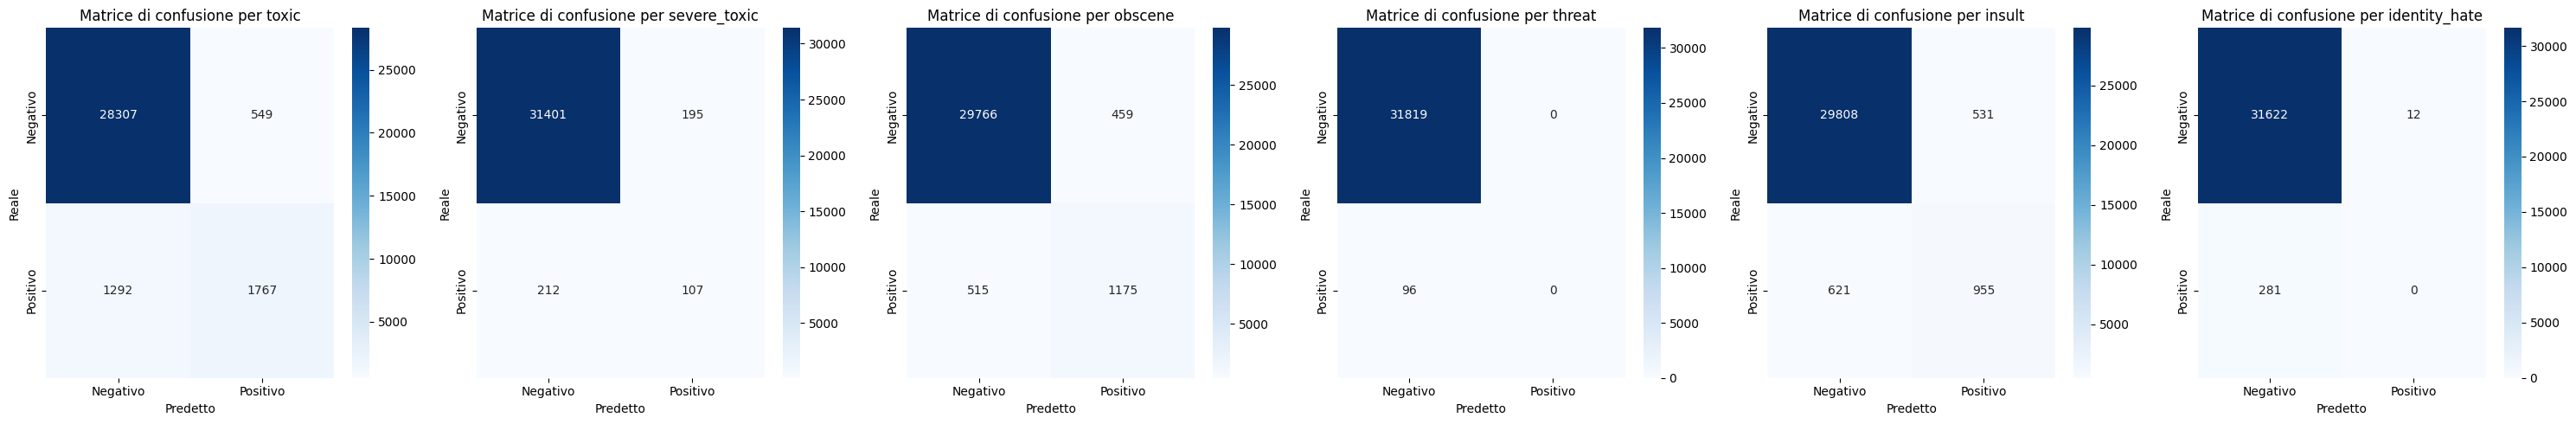

None


In [ ]:
y_pred = model_LSTM.predict(padded_test_sequences)
y_true_array = np.array(y_test)
y_pred_array = np.array(y_pred)

confusion_matrices = plot_multilabel_confusion_matrices(y_true_array, y_pred_array, label_counts)
print(confusion_matrices)

Le matrici di confusione confermano quanto osservato in precedenza: i valori non particolarmente elevati di precisione e recall si traducono in una presenza significativa di falsi positivi e falsi negativi.

Analizzando ciascuna matrice, corrispondente a una specifica classe, si nota infatti che il modello commette un numero non trascurabile di errori nel distinguere correttamente tra istanze positive e negative.

# Conclusioni

Il modello risulta complessivamente efficace nelle sue previsioni, tuttavia il numero rilevante di falsi positivi e falsi negativi evidenzia la necessità di ulteriori ottimizzazioni. Tra i possibili interventi migliorativi si possono considerare:

- Regolare la soglia di classificazione, al fine di ottimizzare la precisione o il recall in base agli obiettivi specifici dell'applicazione

- Sperimentare tecniche di regolarizzazione, per migliorare la capacità di generalizzazione del modello

- Ampliare il dataset, così da ridurre il rischio di overfitting e rendere l’addestramento più robusto